## Analyzing pilot boat

In [23]:
import src.data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

In [24]:
reader = pd.read_csv(src.data.path_lots, chunksize=100000, iterator=True)  # Loading a small part of the data
df_raw = next(reader)
df_raw.set_index('Timestamp [UTC]', inplace=True)

In [25]:
df_raw.describe()

,Latitude (deg),Longitude (deg),Speed over ground (kts),Consumption ME all (L/h),Economy (L/nm),Charge air pressure ME1 (bar),Charge air pressure ME2 (bar),Charger air temp ME1 (°C),Charger air temp ME2 (°C),Consumption ME1 (L/h),Consumption ME2 (L/h),Coolant pressure ME1 (bar),Coolant pressure ME2 (bar),Coolant temp ME1 (°C),Coolant temp ME2 (°C),Engine load ME1 (%),Engine load ME2 (%),Engine speed ME1 (rpm),Engine speed ME2 (rpm),Exhaust temp ME1 (°C),Exhaust temp ME2 (°C),Fuel bunkering (manual) (L),Fuel pressure ME1 (bar),Fuel pressure ME2 (bar),Lube oil consumption port side (manual) (L),Lube oil consumption starboard side (manual) (L),Sea water pressure ME1 (bar),Sea water pressure ME2 (bar)
count,100000.000000,100000.000000,100000.000000,100000.000000,20311.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,100000.0,100000.0,100000.000000,100000.000000
mean,57.678260,11.853593,2.313290,19.978080,6.154335,0.160867,0.160919,50.023730,48.52861,9.739588,10.238492,0.505279,0.469401,54.456450,52.578890,10.048240,10.373720,233.057520,237.50905,107.509670,109.002610,0.0,0.825890,0.779793,0.0,0.0,0.134782,0.096334
std,0.013939,0.057770,6.083637,61.351001,5.911433,0.536704,0.540521,24.027049,23.99431,30.072731,31.438251,0.698552,0.725604,26.977951,26.268164,25.475854,26.305005,574.769717,587.50329,132.553286,135.452389,0.0,1.834953,1.780835,0.0,0.0,0.338333,0.244850
min,57.588500,11.521210,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,17.00000,0.000000,0.000000,0.000000,0.000000,18.000000,17.000000,0.000000,0.000000,0.000000,0.00000,15.000000,15.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
25%,57.682150,11.871840,0.000000,0.000000,2.018545,0.000000,0.000000,26.000000,24.00000,0.000000,0.000000,0.040000,0.000000,22.000000,21.000000,0.000000,0.000000,0.000000,0.00000,19.000000,19.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
50%,57.682160,11.871850,0.000000,0.000000,5.402170,0.000000,0.000000,45.000000,44.00000,0.000000,0.000000,0.280000,0.220000,57.000000,56.000000,0.000000,0.000000,0.000000,0.00000,42.000000,42.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
75%,57.682170,11.871860,0.000000,0.000000,10.514060,0.000000,0.000000,75.000000,74.00000,0.000000,0.000000,0.600000,0.560000,82.000000,79.000000,0.000000,0.000000,0.000000,0.00000,125.000000,127.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
max,57.691160,11.876980,27.000000,263.900000,108.600000,2.560000,2.400000,90.000000,88.00000,131.700000,132.300000,3.060000,3.060000,90.000000,89.000000,100.000000,100.000000,2253.999940,2265.99998,486.000000,511.000000,0.0,5.760000,5.640000,0.0,0.0,1.400000,1.100000


In [52]:
mask = df_raw.std() > 0
interesting=df_raw.columns[mask]
df = df_raw[interesting].copy()

mask = df['Speed over ground (kts)']>5
df=df.loc[mask]
df = df.iloc[0:10000]


In [53]:
df.describe()

,Latitude (deg),Longitude (deg),Speed over ground (kts),Consumption ME all (L/h),Economy (L/nm),Charge air pressure ME1 (bar),Charge air pressure ME2 (bar),Charger air temp ME1 (°C),Charger air temp ME2 (°C),Consumption ME1 (L/h),Consumption ME2 (L/h),Coolant pressure ME1 (bar),Coolant pressure ME2 (bar),Coolant temp ME1 (°C),Coolant temp ME2 (°C),Engine load ME1 (%),Engine load ME2 (%),Engine speed ME1 (rpm),Engine speed ME2 (rpm),Exhaust temp ME1 (°C),Exhaust temp ME2 (°C),Fuel pressure ME1 (bar),Fuel pressure ME2 (bar),Sea water pressure ME1 (bar),Sea water pressure ME2 (bar)
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,57.654574,11.750207,15.857600,138.932109,7.379835,1.140050,1.135226,38.928900,35.934600,67.981459,70.950650,1.932426,1.952682,85.020600,82.263000,66.448000,68.128000,1523.465400,1551.808999,393.815200,398.511800,5.033372,4.876404,0.883476,0.630140
std,0.030540,0.105940,7.120191,104.705178,3.484011,0.999077,1.009931,5.219326,3.875464,51.716627,53.585364,0.849094,0.916713,7.674964,7.445185,28.020964,29.186548,562.299619,582.983066,59.870775,61.288414,0.520958,0.564646,0.352823,0.270065
min,57.588500,11.521210,5.100000,0.000000,0.000000,0.000000,0.000000,18.000000,18.000000,0.000000,0.000000,0.280000,0.320000,25.000000,22.000000,0.000000,0.000000,652.000010,347.000000,169.000000,214.000000,3.960000,3.520000,0.220000,0.120000
25%,57.633347,11.664817,9.300000,38.600000,4.167720,0.160000,0.120000,35.000000,34.000000,18.500000,19.500000,1.200000,1.140000,86.000000,83.000000,40.000000,40.000000,1004.000020,1025.000040,356.000000,357.000000,4.600000,4.360000,0.560000,0.380000
50%,57.664505,11.784880,12.700000,94.400000,7.787670,0.700000,0.720000,38.000000,36.000000,44.800000,50.000000,1.620000,1.660000,87.000000,84.000000,55.000000,58.000000,1375.999950,1417.000010,418.000000,427.000000,5.040000,4.800000,0.920000,0.660000
75%,57.681820,11.846422,23.800000,259.899990,10.747930,2.280000,2.220000,44.000000,38.000000,129.700000,130.200000,2.900000,2.980000,87.000000,85.000000,100.000000,100.000000,2145.999980,2187.000050,446.000000,444.000000,5.560000,5.440000,1.220000,0.880000
max,57.691160,11.876850,27.000000,263.400010,19.941750,2.560000,2.400000,55.000000,54.000000,131.700000,132.300000,3.060000,3.060000,90.000000,89.000000,100.000000,100.000000,2253.999940,2258.000110,469.000000,485.000000,5.760000,5.600000,1.400000,1.100000


In [54]:
df.columns

Index(['Latitude (deg)', 'Longitude (deg)', 'Speed over ground (kts)',
       'Consumption ME all (L/h)', 'Economy (L/nm)',
       'Charge air pressure ME1 (bar)', 'Charge air pressure ME2 (bar)',
       'Charger air temp ME1 (°C)', 'Charger air temp ME2 (°C)',
       'Consumption ME1 (L/h)', 'Consumption ME2 (L/h)',
       'Coolant pressure ME1 (bar)', 'Coolant pressure ME2 (bar)',
       'Coolant temp ME1 (°C)', 'Coolant temp ME2 (°C)', 'Engine load ME1 (%)',
       'Engine load ME2 (%)', 'Engine speed ME1 (rpm)',
       'Engine speed ME2 (rpm)', 'Exhaust temp ME1 (°C)',
       'Exhaust temp ME2 (°C)', 'Fuel pressure ME1 (bar)',
       'Fuel pressure ME2 (bar)', 'Sea water pressure ME1 (bar)',
       'Sea water pressure ME2 (bar)'],
      dtype='object')

In [55]:
interesting = [
              'Consumption ME all (L/h)',
               'Economy (L/nm)',
               'Speed over ground (kts)',
              'Engine speed ME1 (rpm)',
              'Engine speed ME2 (rpm)',
              
              ]
data = df[interesting].copy()
data.dropna(how='any', inplace = True)

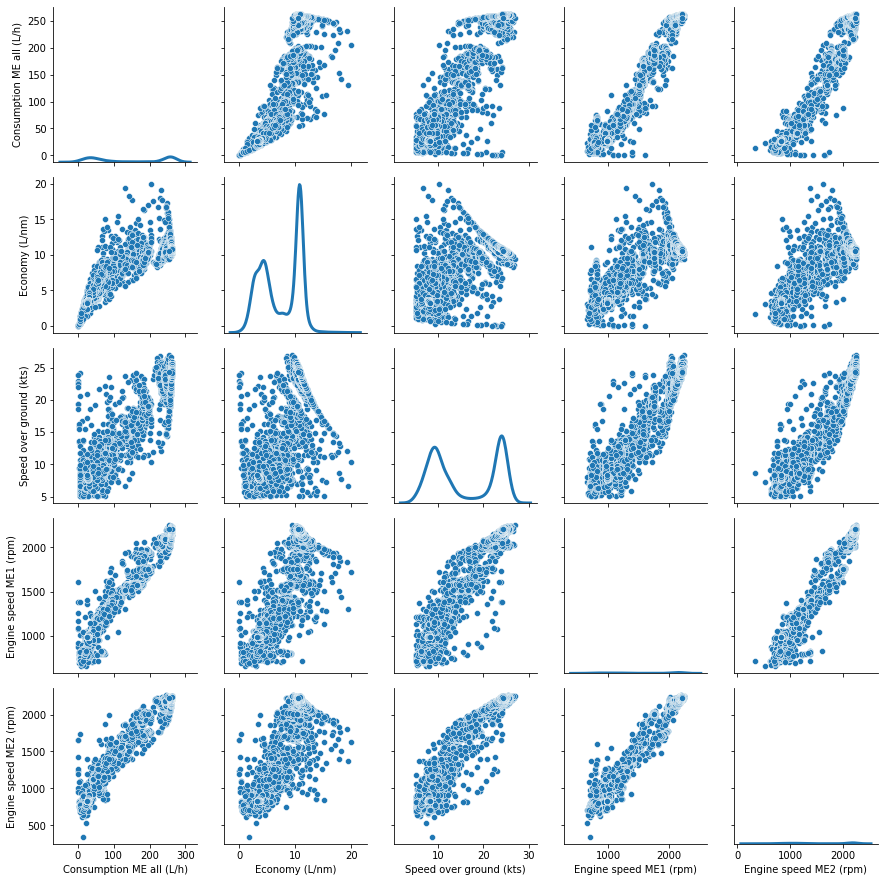

In [56]:
g = sns.PairGrid(data)
g.map_upper(sns.scatterplot)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3, legend=False);

In [ ]:
#g = sns.PairGrid(data)
#g.map_upper(sns.kdeplot)
#g.map_lower(sns.kdeplot)
#g.map_diag(sns.kdeplot, lw=3, legend=False);

## Regression

In [64]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression

select_k_best = SelectKBest(score_func=f_regression, k=4)
standard_scaler = StandardScaler()
polynomial_features = PolynomialFeatures(degree=2)
linear_regression = LinearRegression()

steps = [
    ('scaler', standard_scaler),
    ('polynomial_features', polynomial_features),
    ('select_k_best', select_k_best),
    ('linear_regression', linear_regression),
]

pipeline_polynomial_scaled_selection = Pipeline(steps=steps)

In [68]:
X = data[['Speed over ground (kts)']].copy()
X['Engine speed'] = (data['Engine speed ME1 (rpm)'] + data['Engine speed ME2 (rpm)'])/2
y = data['Consumption ME all (L/h)']                        
              

In [65]:
from sklearn.model_selection import GridSearchCV

# define the grid
grid = dict()
grid['select_k_best__k'] = [i for i in range(X.shape[1]-20, X.shape[1]+1)]
grid['polynomial_features__degree'] = [i for i in range(1, 10)]


# define the grid search
search = GridSearchCV(estimator=pipeline_polynomial_scaled_selection, param_grid=grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)
# perform the search
search_result = search.fit(X, y)

NameError: name 'X' is not defined